In [131]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")
import pickle

In [132]:
def backup(object, filename):
    with open(filename, 'wb') as f:
        pickle.dump(object, f, pickle.HIGHEST_PROTOCOL)

def reload(persist):
    with open(persist, 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        data = pickle.load(f)
    return data

In [2]:
pathCSV = r'ProcessedDataCenterHall.csv'
df = pd.read_csv(pathCSV, index_col=0, parse_dates=True)

In [3]:
dfrefrange = pd.read_csv("ngboost_dataset.gz", index_col=0, parse_dates=True)

In [4]:
#truncate the data same as in ngboost dataset
df = df.loc[dfrefrange.index,:]

In [5]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [6]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:")
        print("Fail to reject the null hypothesis")
        print("series is non-stationary")

In [7]:
for name, column in df[['RealPower', 'ReactivePower']].iteritems():
    Augmented_Dickey_Fuller_Test_func(df[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: RealPower
Test Statistic                -1.334002e+01
p-value                        5.945867e-25
No Lags Used                   4.000000e+01
Number of Observations Used    1.330800e+04
Critical Value (1%)           -3.430841e+00
Critical Value (5%)           -2.861757e+00
Critical Value (10%)          -2.566886e+00
dtype: float64
Conclusion:
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: ReactivePower
Test Statistic                -1.393307e+01
p-value                        5.048327e-26
No Lags Used                   4.100000e+01
Number of Observations Used    1.330700e+04
Critical Value (1%)           -3.430842e+00
Critical Value (5%)           -2.861757e+00
Critical Value (10%)          -2.566886e+00
dtype: float64
Conclusion:
Reject the null hypothesis
Data is stationary




In [8]:
test_obs = int(0.8*(len(df)))
train = df[:test_obs]
test = df[test_obs:]


In [9]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df): 
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [10]:
# train_diff = train.diff()
train_diff = train.copy()
train_diff.dropna(inplace = True)

In [11]:
cointegration_test(train_diff[list(df.columns)])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
RealPower >  189.26    > 12.3212   =>   True
ReactivePower >  14.01     > 4.1296    =>   True


In [12]:
from pmdarima import auto_arima

In [13]:
pq = []
for name, column in train_diff[list(df.columns)].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(train_diff[name],start_p=1, start_q=1,max_p=20, max_q=20, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : RealPower
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=65922.265, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=66645.375, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=65925.080, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=65943.474, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=66643.376, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=65924.084, Time=2.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=65755.288, Time=3.86 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=65921.574, Time=1.61 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=65752.635, Time=4.98 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=15.99 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=65683.547, Time=7.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=65746.701, Time=4.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=65631.679, Time=15.36 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=65593

In [14]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [17]:
pq

[(4, 1, 2), (10, 1, 5)]

In [18]:
df_results_moni = pd.DataFrame(columns=['p', 'q','RealPower','ReactivePower'])
print('Grid Search Started')
start = timer()
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(train_diff[list(df.columns)], order=(i[0],i[2])).fit( disp=False)
        result = model.forecast(steps = test['RealPower'].shape[0])
        # inv_res = inverse_diff(train_diff[list(df.columns)] , result)
        inv_res = result.copy()
        RealPowerrmse = np.sqrt(metrics.mean_squared_error(test['RealPower'], inv_res.RealPower))
        ReactivePowerrmse = np.sqrt(metrics.mean_squared_error(test['ReactivePower'], inv_res.ReactivePower))
        df_results_moni = df_results_moni.append({'p': i[0], 'q': i[2], 'RMSE RealPower':RealPowerrmse,'RMSE ReactivePower':ReactivePowerrmse}, ignore_index=True)
end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')

Grid Search Started
 Running for (4, 1, 2)
 Running for (10, 1, 5)
 Total time taken to complete grid search in seconds: 238.5797092000139


In [19]:
df_results_moni

,p,q,RealPower,ReactivePower,RMSE ReactivePower,RMSE RealPower
0,4.0,2.0,NaN,NaN,13.578947,39.320455
1,10.0,5.0,NaN,NaN,13.555902,39.257086


In [20]:
# from above example we can see that p=10 and q=5 gives least RMSE
model = VARMAX(train[list(df.columns)], order=(10,5)).fit( disp=False)


In [37]:
#test it out
result = model.get_forecast(steps = 4) 

In [38]:
result.predicted_mean

,RealPower,ReactivePower
10679,78.482436,45.772356
10680,78.335489,45.323569
10681,79.006597,45.447791
10682,79.600766,45.512100


In [39]:
result.conf_int(alpha=0.25) #quartile

,lower RealPower,lower ReactivePower,upper RealPower,upper ReactivePower
10679,72.774873,42.427743,84.189998,49.116968
10680,69.423684,40.223559,87.247295,50.423578
10681,67.859898,39.215777,90.153297,51.679804
10682,66.746653,38.516637,92.454880,52.507563


In [41]:
forecast_step = 4
numiters = test.shape[0]-forecast_step+1

In [148]:
errors = {}
regionfit = {}

for _ in range(forecast_step):
    errors[str(_)] = []
    regionfit[str(_)] = []

In [149]:
from numpy import linalg as LA

In [150]:
for ct in range(numiters):
    model_infer = model.apply(pd.concat([train.iloc[ct:,:],test.iloc[:ct,:]]))
    result = model_infer.get_forecast(steps = forecast_step)
    conf_interval = result.conf_int(alpha = 0.75) #quartile?
    for _ in range(forecast_step):
        #error
        errorraw = result.predicted_mean.iloc[_:_+1,:].values - test.iloc[ct:ct+_+1,:].values
        errors[str(_)].append(np.apply_along_axis(LA.norm,1,errorraw)[0])
        
        #predictinterval
        boolresult = test.iloc[ct+_:ct+_+1,0].values > conf_interval['lower RealPower'].iloc[_] and \
        test.iloc[ct+_:ct+_+1,0].values < conf_interval['upper RealPower'].iloc[_] and \
        test.iloc[ct+_:ct+_+1,1].values > conf_interval['lower ReactivePower'].iloc[_] and \
        test.iloc[ct+_:ct+_+1,1].values < conf_interval['upper ReactivePower'].iloc[_]

        regionfit[str(_)].append(boolresult[0])

In [152]:
backup((errors,regionfit),"varmax_results.pickle")

In [153]:
pd.DataFrame(errors).apply(np.mean)

0    4.116195
1    4.844249
2    5.807741
3    6.865776
dtype: float64

### MSE for the each time step:
0    4.116195 \
1    4.844249 \
2    5.807741 \
3    6.865776 \
dtype: float64

In [151]:
for _ in range(forecast_step):
    print(pd.DataFrame(regionfit).iloc[:,_].value_counts()[True]/pd.DataFrame(regionfit).shape[0])

0.2388451443569554
0.24109486314210724
0.24109486314210724
0.2268466441694788


### prediction interval fraction for each timestep
0.2388451443569554 \
0.24109486314210724 \
0.24109486314210724 \
0.2268466441694788

In [146]:
result.conf_int(alpha = 0.95)

,lower RealPower,lower ReactivePower,upper RealPower,upper ReactivePower
2020-02-28 23:15:00,106.612216,54.086255,107.234467,54.450892
2020-02-28 23:30:00,105.480395,53.771114,106.451980,54.327128
2020-02-28 23:45:00,105.410504,54.316110,106.625741,54.995537
2020-02-29 00:00:00,103.719814,53.783443,105.121197,54.546104


In [141]:
pd.DataFrame(regionfit).shape[0]

2667

In [71]:
_ = 0
ct = 0

testind = test.iloc[ct:ct+_+1,:].values
testind > conf_interval['lower RealPower'].iloc[_] and 

78.48243588055456

In [85]:
testind = test.iloc[ct:ct+_+1,0].values
testind > conf_interval['lower RealPower'].iloc[_]

array([ True])

In [97]:
test

,RealPower,ReactivePower
DateTime,,
2020-02-01 04:45:00,78.499,45.929
2020-02-01 05:00:00,79.588,46.052
2020-02-01 05:15:00,78.472,45.061
2020-02-01 05:30:00,78.282,43.569
2020-02-01 05:45:00,78.297,43.933
...,...,...
2020-02-28 23:00:00,109.170,54.784
2020-02-28 23:15:00,69.224,45.003
2020-02-28 23:30:00,63.853,42.326


In [77]:
conf_interval

In [84]:
result = model.forecast(steps = 4)

In [63]:
# res = inverse_diff(df[list(df.columns)],result)
# res.drop(labels=['RealPower','ReactivePower'],axis=1,inplace=True)
# res.index = test.index

In [86]:
result.index=test.iloc[:4,:].index

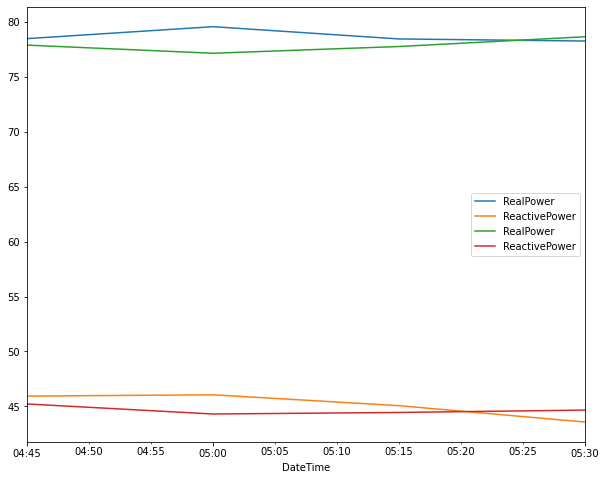

In [88]:
pd.concat([test,result],axis=1).iloc[:4,:].plot(figsize=(10,8))

In [101]:
model_infer = model.apply(pd.concat([train.iloc[8:,:],test.iloc[:8,:]]))

In [102]:
result = model_infer.forecast(steps = 4)

In [103]:
result.index=test.iloc[8:12,:].index

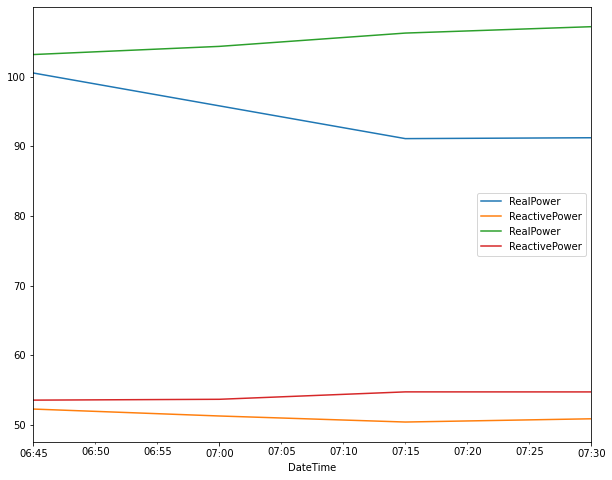

In [104]:
pd.concat([test,result],axis=1).iloc[8:12,:].plot(figsize=(10,8))

In [99]:
pd.concat([test,result],axis=1)

,RealPower,ReactivePower,RealPower,ReactivePower
DateTime,,,,
2020-02-01 04:45:00,78.499,45.929,NaN,NaN
2020-02-01 05:00:00,79.588,46.052,NaN,NaN
2020-02-01 05:15:00,78.472,45.061,NaN,NaN
2020-02-01 05:30:00,78.282,43.569,NaN,NaN
2020-02-01 05:45:00,78.297,43.933,78.779856,43.679441
...,...,...,...,...
2020-02-28 23:00:00,109.170,54.784,NaN,NaN
2020-02-28 23:15:00,69.224,45.003,NaN,NaN
2020-02-28 23:30:00,63.853,42.326,NaN,NaN
